# Memilih DPI Part 2
**Kenapa ada Part 2?**

Dalam pemilihan dpi di notebook sebelumnya, sum of squared error (SSE) berperan penting untuk menentukan dpi yang akan digunakan. Akan tetapi, ternyata ada parameter lain yang terlupa, yaitu selisih `cmyk` atau `sum` dari **base dpi** (300 DPI) untuk setiap DPI nya. Untuk itu dalam notebook ini kita akan membandingkan setiap metode converting untuk mengetahui seberapa jauh selisihnya dengan **base dpi**

In [1]:
import pypdfium2 as pdfium
from pypdfium2._helpers.bitmap import PdfBitmap
import PIL
import os, sys, time
import pandas as pd

sys.path.append(os.path.abspath(".."))
from src.helper import calculate_cmyk_percentage, rgb_to_cmyk, log

In [2]:
df = pd.read_csv("../datasets/cmyk-by-dpi.csv")
base_df = df[df['dpi'] == 300].copy()
base_df['sum']

0      157.95
1        0.07
2       15.69
3        2.99
4        4.03
        ...  
847      0.07
848      7.15
849      6.86
850      0.07
851    157.25
Name: sum, Length: 852, dtype: float64

## pypdfium2 Text-Antialiasing Enabled

In [3]:
pdf = pdfium.PdfDocument("../datasets/statistik-indonesia-2024.pdf")


cmyk_by_dpi = {
    'converting_time': [],
    'page': [],
    'dpi': [],
    'c': [],
    'm': [],
    'y': [],
    'k': [],
    'sum': [],
    'base_minus_curr_sum': [],
    'diff': [], # diff from the base dpi (300 dpi) in jpg format, no additional setting
}

# Load base df 300 dpi
df = pd.read_csv("../datasets/cmyk-by-dpi.csv")
base_df = df[df['dpi'] == 300].copy()

pdf_length = len(pdf)
for dpi in [5] + list(range(10, 301, 10)):
    print(f"start process for {dpi} dpi...")
    for i in range(pdf_length):
        start = time.time()
        bitmap = pdf[i].render(
            scale = 1/72 * dpi, # 5 DPI
            no_smoothtext = True, # Anti-aliasing text
        )
        pil_image = bitmap.to_pil()
        c, m, y, k = calculate_cmyk_percentage(pil_image)
        sum_of_cmyk = c + m + y + k
        base_minus_curr_sum = base_df['sum'][i] - sum_of_cmyk
        
        cmyk_by_dpi['converting_time'].append(time.time() - start)
        cmyk_by_dpi['page'].append(i+1)
        cmyk_by_dpi['dpi'].append(dpi)
        cmyk_by_dpi['c'].append(c)
        cmyk_by_dpi['m'].append(m)
        cmyk_by_dpi['y'].append(y)
        cmyk_by_dpi['k'].append(k)
        cmyk_by_dpi['sum'].append(sum_of_cmyk)
        cmyk_by_dpi['base_minus_curr_sum'].append(base_minus_curr_sum)
        cmyk_by_dpi['diff'].append(abs(base_minus_curr_sum))

        # Clean up memory
        del start, bitmap, pil_image, c, m, y, k, sum_of_cmyk, base_minus_curr_sum
        
    print(f"finish process for {dpi} dpi...")
    

start process for 5 dpi...
finish process for 5 dpi...
start process for 10 dpi...
finish process for 10 dpi...
start process for 20 dpi...
finish process for 20 dpi...
start process for 30 dpi...
finish process for 30 dpi...
start process for 40 dpi...
finish process for 40 dpi...
start process for 50 dpi...
finish process for 50 dpi...
start process for 60 dpi...
finish process for 60 dpi...
start process for 70 dpi...
finish process for 70 dpi...
start process for 80 dpi...
finish process for 80 dpi...
start process for 90 dpi...
finish process for 90 dpi...
start process for 100 dpi...
finish process for 100 dpi...
start process for 110 dpi...
finish process for 110 dpi...
start process for 120 dpi...
finish process for 120 dpi...
start process for 130 dpi...
finish process for 130 dpi...
start process for 140 dpi...
finish process for 140 dpi...
start process for 150 dpi...
finish process for 150 dpi...
start process for 160 dpi...
finish process for 160 dpi...
start process for 1

In [4]:
df = pd.DataFrame(cmyk_by_dpi)
df

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
0,0.276888,1,5,55.87,0.63,52.46,44.06,153.02,4.93,4.93
1,0.001188,2,5,0.00,0.00,0.00,0.07,0.07,0.00,0.00
2,0.216217,3,5,3.46,0.13,9.02,3.31,15.92,-0.23,0.23
3,0.018973,4,5,0.00,0.29,0.22,2.24,2.75,0.24,0.24
4,0.011587,5,5,0.00,0.00,0.00,0.07,0.07,3.96,3.96
...,...,...,...,...,...,...,...,...,...,...
26407,0.807454,848,300,0.00,0.00,0.00,0.06,0.06,0.01,0.01
26408,0.840801,849,300,1.03,0.41,2.07,4.07,7.58,-0.43,0.43
26409,0.818293,850,300,1.04,0.37,2.04,3.79,7.24,-0.38,0.38
26410,0.802590,851,300,0.00,0.00,0.00,0.06,0.06,0.01,0.01


In [5]:
df.to_csv("../datasets/cmyk-by-dpi-anti-aliasing.csv", index=False)

In [6]:
df[(df['diff']<1) & (df['dpi']<=50)]

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
1,0.001188,2,5,0.00,0.00,0.00,0.07,0.07,0.00,0.00
2,0.216217,3,5,3.46,0.13,9.02,3.31,15.92,-0.23,0.23
3,0.018973,4,5,0.00,0.29,0.22,2.24,2.75,0.24,0.24
9,0.001135,10,5,0.00,0.00,0.00,0.07,0.07,0.00,0.00
11,0.011572,12,5,0.85,0.05,1.51,1.50,3.91,0.51,0.51
...,...,...,...,...,...,...,...,...,...,...
5100,0.016433,841,50,2.77,0.39,7.61,6.26,17.03,-0.63,0.63
5106,0.012457,847,50,0.32,0.21,0.83,1.92,3.28,-0.98,0.98
5107,0.009173,848,50,0.00,0.00,0.00,0.07,0.07,0.00,0.00
5110,0.009172,851,50,0.00,0.00,0.00,0.07,0.07,0.00,0.00


In [7]:
df_base_antialiasing = df[df['dpi'] == 300].copy()
df_base_antialiasing.to_csv("../datasets/cmyk_base_antialiasing.csv")

In [10]:
diff = []
for i,row in enumerate(df.iterrows()):
    curr_sum = row[1]['sum']
    base_sum = df_base_antialiasing[df_base_antialiasing['page'] == row[1]['page']]['sum'].iloc[0]
    diff.append(abs(curr_sum - base_sum))
    # print(curr_sum, base_sum)
    # if i == 5:
    #     break
        
df

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
0,0.276888,1,5,55.87,0.63,52.46,44.06,153.02,4.93,4.93
1,0.001188,2,5,0.00,0.00,0.00,0.07,0.07,0.00,0.00
2,0.216217,3,5,3.46,0.13,9.02,3.31,15.92,-0.23,0.23
3,0.018973,4,5,0.00,0.29,0.22,2.24,2.75,0.24,0.24
4,0.011587,5,5,0.00,0.00,0.00,0.07,0.07,3.96,3.96
...,...,...,...,...,...,...,...,...,...,...
26407,0.807454,848,300,0.00,0.00,0.00,0.06,0.06,0.01,0.01
26408,0.840801,849,300,1.03,0.41,2.07,4.07,7.58,-0.43,0.43
26409,0.818293,850,300,1.04,0.37,2.04,3.79,7.24,-0.38,0.38
26410,0.802590,851,300,0.00,0.00,0.00,0.06,0.06,0.01,0.01


In [11]:
df['diff'] = diff
df

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
0,0.276888,1,5,55.87,0.63,52.46,44.06,153.02,4.93,4.94
1,0.001188,2,5,0.00,0.00,0.00,0.07,0.07,0.00,0.01
2,0.216217,3,5,3.46,0.13,9.02,3.31,15.92,-0.23,0.32
3,0.018973,4,5,0.00,0.29,0.22,2.24,2.75,0.24,0.50
4,0.011587,5,5,0.00,0.00,0.00,0.07,0.07,3.96,4.53
...,...,...,...,...,...,...,...,...,...,...
26407,0.807454,848,300,0.00,0.00,0.00,0.06,0.06,0.01,0.00
26408,0.840801,849,300,1.03,0.41,2.07,4.07,7.58,-0.43,0.00
26409,0.818293,850,300,1.04,0.37,2.04,3.79,7.24,-0.38,0.00
26410,0.802590,851,300,0.00,0.00,0.00,0.06,0.06,0.01,0.00


In [24]:
df[(df['diff']>=5)]

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
6,0.020922,7,5,0.24,0.00,0.55,0.30,1.09,4.49,5.10
7,0.081687,8,5,1.83,1.25,4.92,18.01,26.01,-13.15,13.43
8,0.067216,9,5,0.94,7.75,9.84,27.52,46.05,-22.18,22.64
15,0.013538,16,5,0.24,0.00,0.54,0.31,1.09,4.65,5.25
17,0.009185,18,5,0.24,0.00,0.54,0.31,1.09,4.74,5.34
...,...,...,...,...,...,...,...,...,...,...
4162,0.012925,755,40,0.37,1.27,1.70,9.98,13.32,-6.32,5.68
4165,0.011689,758,40,0.39,1.17,1.65,9.25,12.46,-5.77,5.16
4169,0.011051,762,40,0.39,1.16,1.65,9.17,12.37,-5.67,5.08
4236,0.016641,829,40,0.38,1.22,1.68,9.62,12.90,-6.12,5.48


In [13]:
df[(df['dpi'] <50 ) & (df['page'] == 1)]

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
0,0.276888,1,5,55.87,0.63,52.46,44.06,153.02,4.93,4.94
852,0.214099,1,10,58.27,1.25,52.31,43.77,155.60,2.35,2.36
1704,0.222650,1,20,59.60,1.60,52.18,43.53,156.91,1.04,1.05
2556,0.229140,1,30,60.06,1.72,52.13,43.44,157.35,0.60,0.61
3408,0.253920,1,40,60.38,1.81,52.10,43.36,157.65,0.30,0.31


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

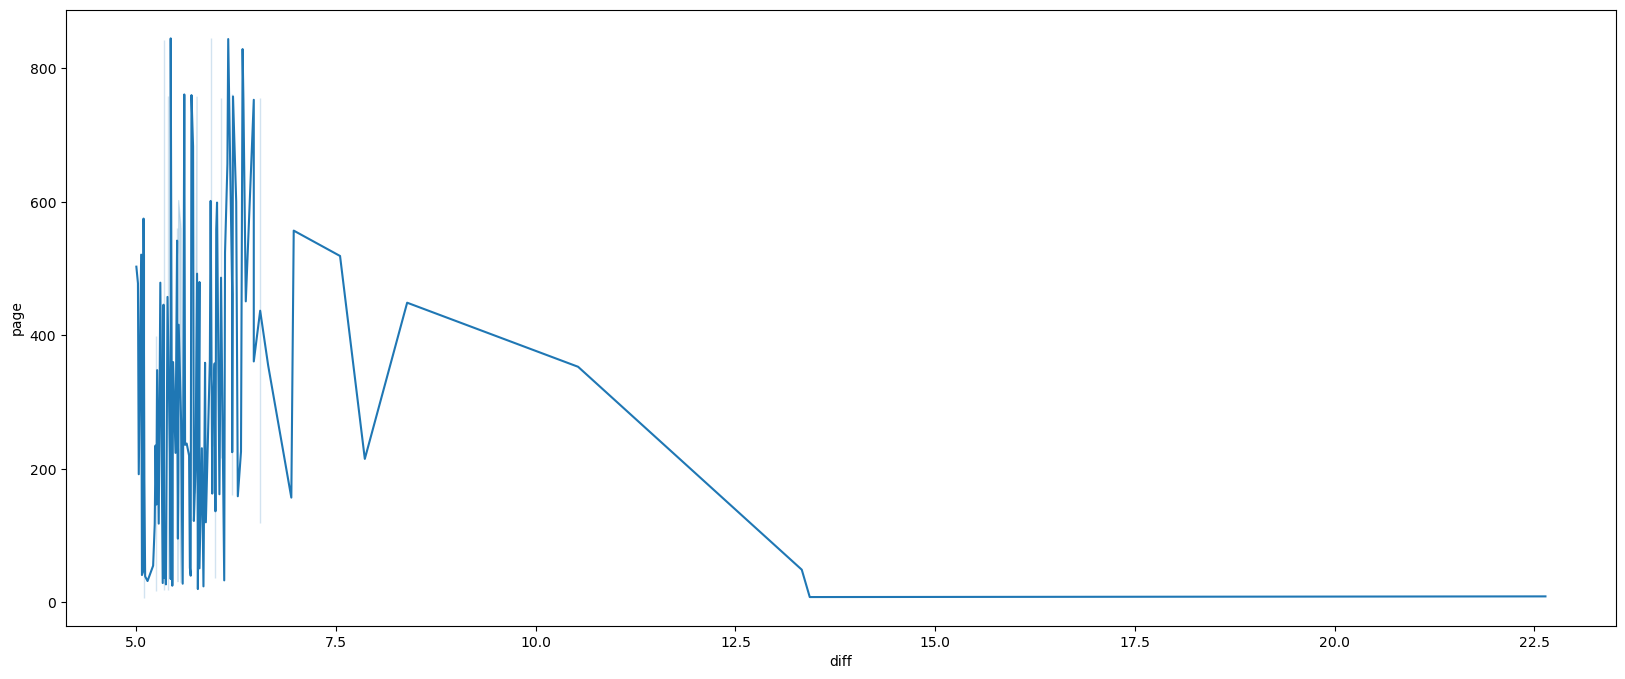

In [47]:
plt.figure(figsize=(20, 8))
sns.lineplot(df[(df['diff']>=5) & (df['dpi']==5)], x='diff', y='page')
plt.show()

In [48]:
df[(df['diff']>=10) & (df['dpi']==5)]

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
7,0.081687,8,5,1.83,1.25,4.92,18.01,26.01,-13.15,13.43
8,0.067216,9,5,0.94,7.75,9.84,27.52,46.05,-22.18,22.64
48,0.038050,49,5,17.16,3.00,24.41,19.58,64.15,-13.71,13.33
352,34.249944,353,5,39.48,0.97,35.81,30.40,106.66,-10.88,10.53


In [57]:
df_no_antialiasing = pd.read_csv("../datasets/cmyk-by-dpi.csv")
df_base_no_antialiasing = df_no_antialiasing[df_no_antialiasing['dpi'] == 300].copy().reset_index()
df_base_no_antialiasing

,index,page,dpi,processing_time,c,m,y,k,sum
0,0,1,300,0.915638,60.78,1.99,52.04,43.14,157.95
1,1,2,300,0.886884,0.00,0.00,0.00,0.07,0.07
2,2,3,300,0.909601,3.49,0.16,9.08,2.96,15.69
3,3,4,300,0.902281,0.00,0.16,0.09,2.74,2.99
4,4,5,300,0.888387,0.00,0.11,0.05,3.87,4.03
...,...,...,...,...,...,...,...,...,...
847,847,848,300,0.886205,0.00,0.00,0.00,0.07,0.07
848,848,849,300,0.885225,1.03,0.11,1.82,4.19,7.15
849,849,850,300,0.896352,1.04,0.08,1.81,3.93,6.86
850,850,851,300,0.881693,0.00,0.00,0.00,0.07,0.07


In [58]:
diff = []
for i,row in enumerate(df_no_antialiasing.iterrows()):
    curr_sum = row[1]['sum']
    base_sum = df_base_no_antialiasing[df_base_no_antialiasing['page'] == row[1]['page']]['sum'].iloc[0]
    diff.append(abs(curr_sum - base_sum))
    # print(curr_sum, base_sum)
    # if i == 5:
    #     break

In [60]:
df_no_antialiasing['diff'] = diff
df_no_antialiasing

,page,dpi,processing_time,c,m,y,k,sum,diff
0,1,300,0.915638,60.78,1.99,52.04,43.14,157.95,0.00
1,2,300,0.886884,0.00,0.00,0.00,0.07,0.07,0.00
2,3,300,0.909601,3.49,0.16,9.08,2.96,15.69,0.00
3,4,300,0.902281,0.00,0.16,0.09,2.74,2.99,0.00
4,5,300,0.888387,0.00,0.11,0.05,3.87,4.03,0.00
...,...,...,...,...,...,...,...,...,...
7663,848,5,0.001077,0.00,0.00,0.00,0.09,0.09,0.02
7664,849,5,0.000960,1.15,0.30,1.81,4.22,7.48,0.33
7665,850,5,0.000798,1.11,0.32,1.90,3.90,7.23,0.37
7666,851,5,0.000722,0.00,0.00,0.00,0.09,0.09,0.02


In [66]:
df_no_antialiasing[df_no_antialiasing['diff'] >= 5]

,page,dpi,processing_time,c,m,y,k,sum,diff
5119,8,20,0.002243,3.09,0.29,6.53,9.03,18.94,6.08
5120,9,20,0.002118,4.59,3.49,11.46,13.85,33.39,9.52
5971,8,10,0.001304,2.98,0.48,7.00,12.91,23.37,10.51
5972,9,10,0.001183,4.42,5.10,13.07,19.84,42.43,18.56
6816,1,5,0.001745,54.36,0.03,53.03,44.63,152.05,5.90
6823,8,5,0.001186,3.53,0.74,7.31,18.33,29.91,17.05
6824,9,5,0.000878,4.34,11.26,16.23,27.59,59.42,35.55


In [67]:
df[df['diff'] >= 5]

,converting_time,page,dpi,c,m,y,k,sum,base_minus_curr_sum,diff
6,0.020922,7,5,0.24,0.00,0.55,0.30,1.09,4.49,5.10
7,0.081687,8,5,1.83,1.25,4.92,18.01,26.01,-13.15,13.43
8,0.067216,9,5,0.94,7.75,9.84,27.52,46.05,-22.18,22.64
15,0.013538,16,5,0.24,0.00,0.54,0.31,1.09,4.65,5.25
17,0.009185,18,5,0.24,0.00,0.54,0.31,1.09,4.74,5.34
...,...,...,...,...,...,...,...,...,...,...
4162,0.012925,755,40,0.37,1.27,1.70,9.98,13.32,-6.32,5.68
4165,0.011689,758,40,0.39,1.17,1.65,9.25,12.46,-5.77,5.16
4169,0.011051,762,40,0.39,1.16,1.65,9.17,12.37,-5.67,5.08
4236,0.016641,829,40,0.38,1.22,1.68,9.62,12.90,-6.12,5.48


In [72]:
from datetime import datetime

'2024-11-04 21:30:27.371665'